In [1]:
import sys, os
sys.path.insert(0,"/home/yjzhu/scripts/Solar-Wind-Time-Series-Viewer")
os.environ["PSP_DATA_DIR"] = os.path.realpath("../../data/downloads/")


import pyspedas
from pytplot import get_data
from pyspedas import time_string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pathlib import Path
import os
import pickle
from gc import collect
import astropy.units as u
import astropy.constants as const

from scipy.stats import shapiro
from multiprocessing import Pool

# from TSUtilities import FindIntervalInfo
from TimeSeriesViewer import TimeSeriesViewer
from LoadData import LoadHighResMagPSP
from BreakPointFinderGeneral import BreakPointFinder as BPFG
from TSUtilities import smoothing_function, TracePSD, trace_PSD_wavelet

In [2]:
collect()

peri_dates = [pd.Timestamp(x) for x in [
    '2018-11-06/03:27',
    '2019-04-04/22:39',
    '2019-09-01/17:50',
    '2020-01-29/09:37',
    '2020-06-07/08:23',
    '2020-09-27/09:16',
    '2021-01-17/17:40',
    '2021-04-29/08:48',
    '2021-08-09/19:11',
    '2021-11-21/08:23',
    '2022-02-25/15:38',
    '2022-06-01/22:51',
    '2022-09-06/06:04',
    '2022-12-11/13:16',
    '2023-03-17/20:30',
    '2023-06-22/03:46',
    '2023-09-27/23:28',
    '2023-12-29/00:54',
    '2024-03-30/02:20',
    '2024-06-30/03:46',
    '2024-09-30/05:13',
    '2024-12-24/11:41',
    '2025-03-22/22:25',
    '2025-06-19/09:09'
]]

encounter = 23
wing = pd.Timedelta('1d')
t00 = peri_dates[encounter-1] - wing
t10 = peri_dates[encounter-1] + wing

tsv = TimeSeriesViewer(sc = 0, 
                       start_time_0 = t00, 
                       end_time_0 = t10, 
                       resample_rate = '5min', 
                       rolling_rate = '1H', 
                       resolution = 5,
                       LTSWsettings = {'must_have_qtn':False, 'particle_mode':'keep_all'}
                       # LTSWsettings = {'must_have_qtn':False, 'particle_mode':'spc_only'}
                       # LTSWsettings = {'must_have_qtn':False, 'particle_mode':'spc_only'}
                      )
clear_output()

print("t00 = %s, t10 = %s" %(t00, t10))
print("finished loading data")

t00 = 2025-03-21 22:25:00, t10 = 2025-03-23 22:25:00
finished loading data


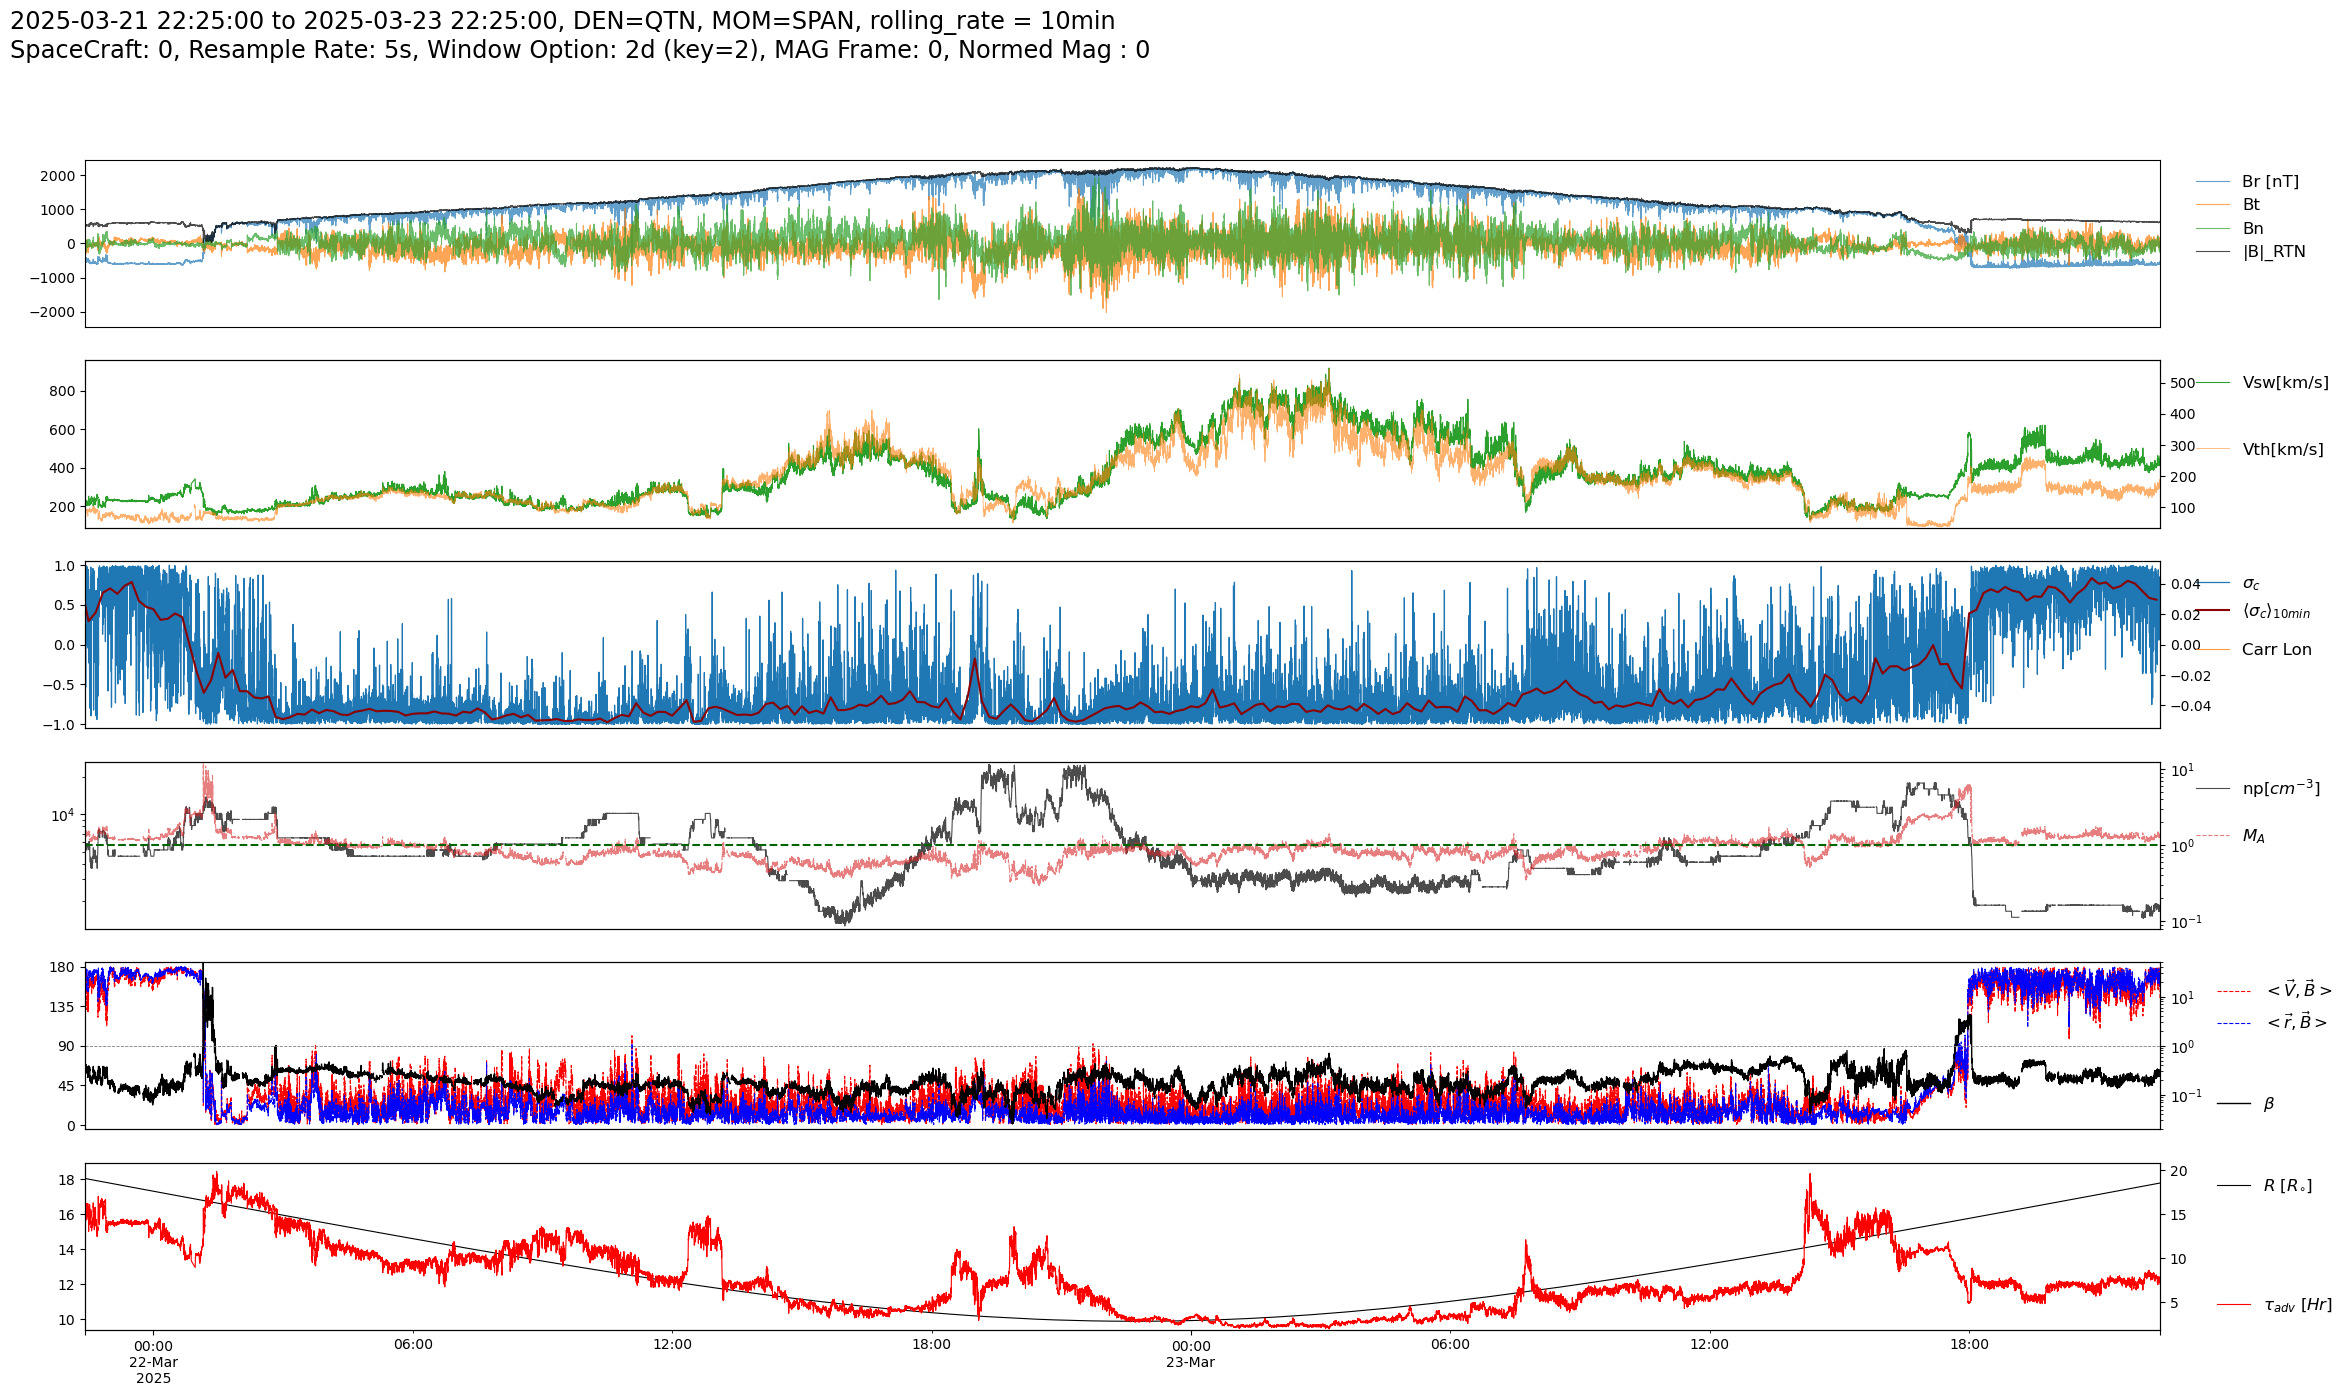

In [3]:
%matplotlib inline
# switch to tk to launch interactive mode
#%matplotlib tk

plt.style.use('default')
collect()
plt.close('all')
tsv.resample_rate = '5s'
tsv.rolling_rate = '10min'
tsv.mag_res = '1s'
tsv.figsize = [25,15]

t0 = t00 + pd.Timedelta('0d')
t1 = t10 - pd.Timedelta('0d')

par_settings = {'density': 'QTN', 'moments': 'SPAN'}#, 'SPAN_settings':{'product':'fit'}}
tsv.use_hampel = True
tsv.hampel_settings = {'window_size': 300, 'n': 6}

tsv.InitFigure(t0, t1, par_settings = par_settings, clean_intervals=True)

plt.subplots_adjust(left = 0.05, right = 0.88, top = 0.88, bottom = 0.1)

tsv.p_funcs = {'show_btot_histogram': {'discard_std':4, 'normality':True, 'downsample_size': 4000}, 'wavelet_PSD':{'coi_thresh': 0.3}, 'struc_funcs':1}

tsv.connect()
clear_output()
plt.savefig(f"../figs/encounter_{encounter:02d}_preview.png", dpi=300)

In [4]:
tsv.dfts.columns

Index(['Br', 'Bt', 'Bn', 'ne_qtn', 'np_qtn', 'te_qtn', 'np_spc', 'Vx_spc',
       'Vy_spc', 'Vz_spc', 'Vr_spc', 'Vt_spc', 'Vn_spc', 'Vth_spc',
       'Dist_au_spc', 'na_spc', 'np_span', 'Vx_span', 'Vy_span', 'Vz_span',
       'Vr_span', 'Vt_span', 'Vn_span', 'Vth_span', 'Dist_au_span', 'na_span',
       'Tp_span', 'Ta_span', 'carr_lon', 'carr_lat', 'np', 'Vx', 'Vy', 'Vz',
       'Vr', 'Vt', 'Vn', 'Vth', 'Dist_au', 'na', 'Tp', 'Ta', 'Br0', 'Bt0',
       'Bn0', 'Vr0', 'Vt0', 'Vn0', 'Vx0', 'Vy0', 'Vz0', 'Vr0_spc', 'Vr0_span',
       'Vt0_spc', 'Vt0_span', 'Vn0_spc', 'Vn0_span', 'Vx0_spc', 'Vx0_span',
       'Vy0_spc', 'Vy0_span', 'Vz0_spc', 'Vz0_span', 'B_RTN', 'V_RTN', 'B_SC',
       'V_SC', 'B', 'V', 'brangle', 'sigma_c', 'alfvenicity', 'sigma_r',
       'vbangle', 'di', 'rho_ci', 'beta', 'vsw', 'tadv', 'valfven', 'malfven',
       'nanp_ratio'],
      dtype='object')

In [5]:
tsv.dfts_raw0.columns

Index(['Br', 'Bt', 'Bn', 'ne_qtn', 'np_qtn', 'te_qtn', 'np_spc', 'Vx_spc',
       'Vy_spc', 'Vz_spc', 'Vr_spc', 'Vt_spc', 'Vn_spc', 'Vth_spc',
       'Dist_au_spc', 'na_spc', 'np_span', 'Vx_span', 'Vy_span', 'Vz_span',
       'Vr_span', 'Vt_span', 'Vn_span', 'Vth_span', 'Dist_au_span', 'na_span',
       'Tp_span', 'Ta_span', 'carr_lon', 'carr_lat', 'np', 'Vx', 'Vy', 'Vz',
       'Vr', 'Vt', 'Vn', 'Vth', 'Dist_au', 'na', 'Tp', 'Ta', 'Br0', 'Bt0',
       'Bn0', 'Vr0', 'Vt0', 'Vn0', 'Vx0', 'Vy0', 'Vz0', 'Vr0_spc', 'Vr0_span',
       'Vt0_spc', 'Vt0_span', 'Vn0_spc', 'Vn0_span', 'Vx0_spc', 'Vx0_span',
       'Vy0_spc', 'Vy0_span', 'Vz0_spc', 'Vz0_span'],
      dtype='object')

In [6]:
au_to_rsun = (1*u.au).to(u.R_sun).value

In [7]:
const.mu0

<<class 'astropy.constants.codata2018.CODATA2018'> name='Vacuum magnetic permeability' value=1.25663706212e-06 uncertainty=1.9e-16 unit='N / A2' reference='CODATA 2018'>

In [8]:
eV_to_erg = ((1 * u.eV).to(u.erg)).value

In [9]:
U_K = 0.5* const.m_e.cgs.value * tsv.dfts['ne_qtn'] * (tsv.dfts['vsw']*1e5)**2 + \
      0.5* const.m_p.cgs.value * tsv.dfts['np_qtn'] * (tsv.dfts['vsw']*1e5)**2 + \
      0.5 * 4 * const.m_p.cgs.value * tsv.dfts['na'] * (tsv.dfts['vsw']*1e5)**2      # in erg/cm3

U_H = 5/2 * tsv.dfts['ne_qtn']  * tsv.dfts['te_qtn'] * eV_to_erg + \
      5/2 * tsv.dfts['np_qtn']  * tsv.dfts['Tp']  * eV_to_erg + \
      5/2 * 4 * tsv.dfts['na']  * tsv.dfts['Ta'] * eV_to_erg   # in erg/cm3

U_G = const.G.cgs.value * const.M_sun.cgs.value * (
    tsv.dfts['ne_qtn'] * const.m_e.cgs.value + \
    tsv.dfts['np_qtn'] * const.m_p.cgs.value + \
    4 * tsv.dfts['na'] * const.m_p.cgs.value
) / const.R_sun.cgs.value * (1 - 1/(tsv.dfts['Dist_au'] * au_to_rsun))   # in erg/cm3

U_W = (3/2 + tsv.dfts['valfven']/(tsv.dfts['vsw'])) * \
    ((tsv.dfts['Br'] - tsv.dfts['Br0'])**2 + (tsv.dfts['Bt'] - tsv.dfts['Bt0'])**2 + (tsv.dfts['Bn'] - tsv.dfts['Bn0'])**2) *1e-18 \
    / (2*const.mu0.value)  *10 

W_K, W_H, W_G, W_W = U_K*tsv.dfts['vsw']*1e5, U_H*tsv.dfts['vsw']*1e5, U_G*tsv.dfts['vsw']*1e5, U_W*tsv.dfts['vsw']*1e5   # in erg/cm2/s
W_K_si, W_H_si, W_G_si, W_W_si = W_K*1e-3, W_H*1e-3, W_G*1e-3, W_W*1e-3   # in W/m2

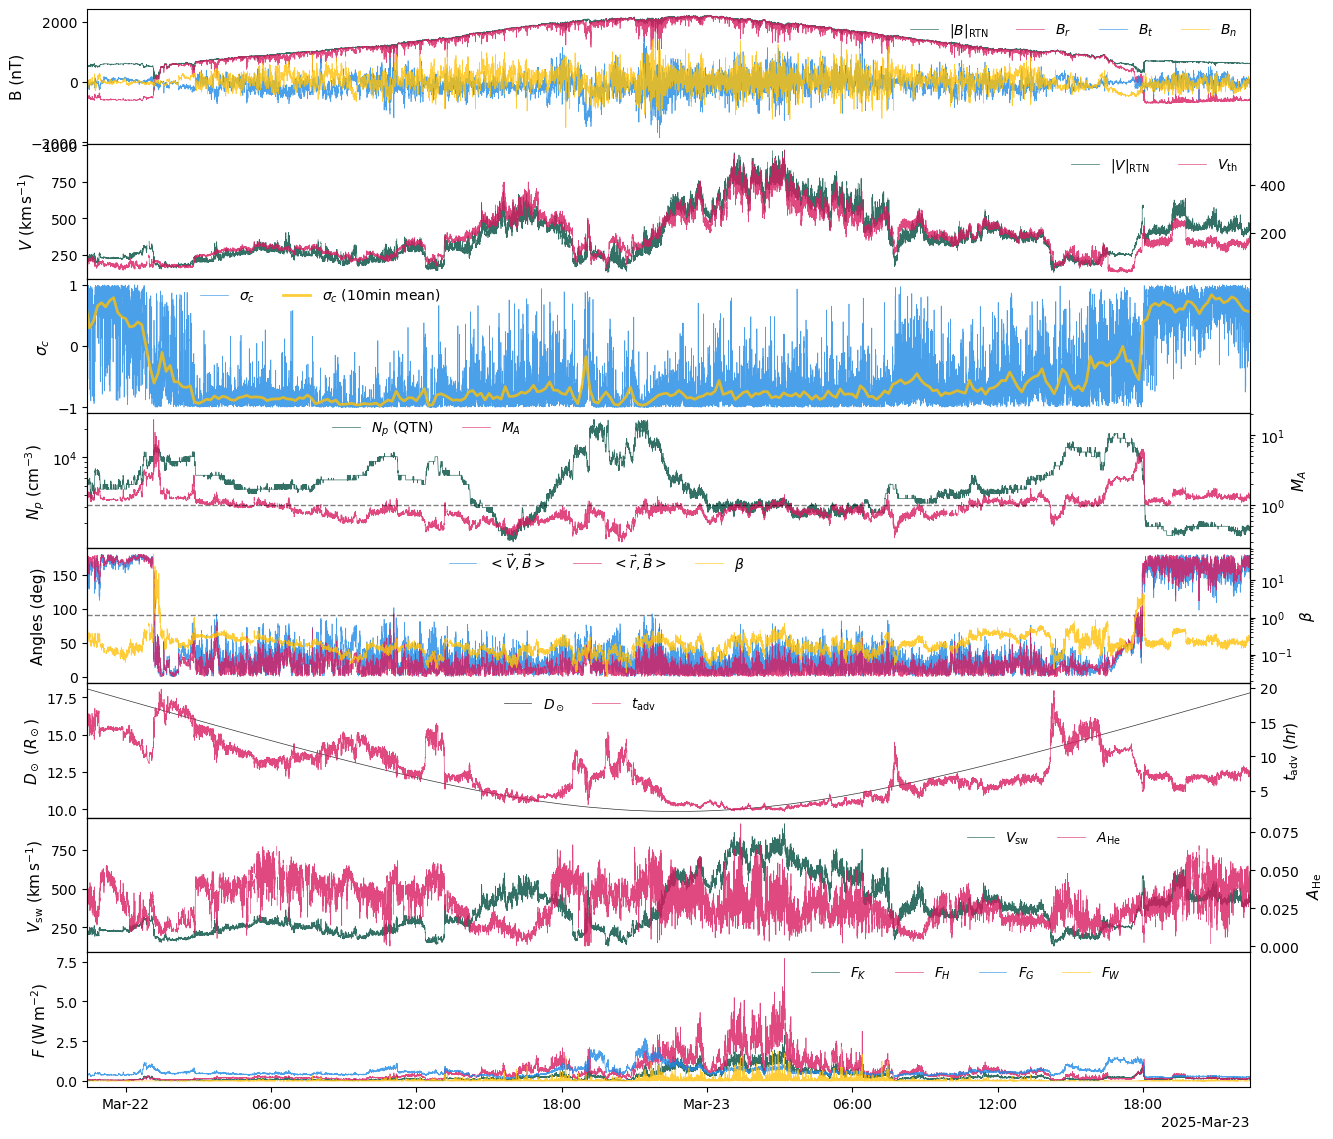

In [10]:
line_width = 0.5
line_alpha = 0.8

with plt.rc_context({'lines.linewidth': line_width}):
    fig, axes = plt.subplots(8,1,figsize=(15,14),gridspec_kw={"hspace":0}, sharex=True)

    axes[0].plot(tsv.dfts.index, tsv.dfts['B_RTN'], color='#004D40', alpha=line_alpha, label=r"$|B|_{\rm RTN}$")
    axes[0].plot(tsv.dfts.index, tsv.dfts['Br'], color='#D81B60', alpha=line_alpha, label=r"$B_r$")
    axes[0].plot(tsv.dfts.index, tsv.dfts['Bt'], color='#1E88E5', alpha=line_alpha, label=r"$B_t$")
    axes[0].plot(tsv.dfts.index, tsv.dfts['Bn'], color='#FFC107', alpha=line_alpha, label=r"$B_n$")

    axes[0].legend(ncol=4, loc='upper right', fontsize=10, frameon=False)
    axes[0].set_xlim(t0, t1)
    axes[0].set_ylabel('B (nT)', fontsize=11)

    axes[1].plot(tsv.dfts.index, tsv.dfts['V_RTN'], color='#004D40', alpha=line_alpha, label=r"$|V|_{\rm RTN}$")
    axes1_right = axes[1].twinx()
    axes1_right.plot(tsv.dfts.index, tsv.dfts['Vth'], color='#D81B60', alpha=line_alpha, label=r"$V_{\rm th}$")

    ax1_handles, ax1_labels = axes[1].get_legend_handles_labels()
    ax1r_handles, ax1r_labels = axes1_right.get_legend_handles_labels()
    axes[1].legend(ax1_handles + ax1r_handles, ax1_labels + ax1r_labels,
                   ncol=2, loc='upper right', fontsize=10, frameon=False)
    axes[1].set_ylabel(r'$V\ (\rm{km\,s^{-1}})$', fontsize=11)

    axes[2].plot(tsv.dfts.index, tsv.dfts['sigma_c'], color='#1E88E5', alpha=line_alpha, label=r"$\sigma_c$")
    axes[2].plot(tsv.dfts['sigma_c'].resample('10min').mean().index, tsv.dfts['sigma_c'].resample('10min').mean(),
                 color='#FFC107', alpha=line_alpha, linestyle='-', label=r"$\sigma_c$ (10min mean)",
                 linewidth=2)
    axes[2].legend(ncol=2, fontsize=10, bbox_to_anchor=(0.2, 0.72), frameon=False)
    axes[2].set_ylabel(r'$\sigma_c$', fontsize=11)

    axes[3].plot(tsv.dfts.index, tsv.dfts['np_qtn'], color='#004D40', alpha=line_alpha, label=r"$N_p$ (QTN)")
    axes3_right = axes[3].twinx()
    axes3_right.plot(tsv.dfts.index, tsv.dfts['malfven'], color='#D81B60', alpha=line_alpha, label=r"$M_A$")
    axes3_right.axhline(1, color='k', linestyle='--', linewidth=1, alpha=0.5)
    axes[3].set_yscale('log')
    axes3_right.set_yscale('log')
    ax3_handles, ax3_labels = axes[3].get_legend_handles_labels()
    ax3r_handles, ax3r_labels = axes3_right.get_legend_handles_labels()
    axes[3].legend(ax3_handles + ax3r_handles, ax3_labels + ax3r_labels,
                   ncol=2, fontsize=10, frameon=False,
                   bbox_to_anchor=(0.2, 0.72))
    axes[3].set_ylabel(r'$N_p\ (\rm{cm^{-3}})$', fontsize=11)
    axes3_right.set_ylabel(r'$M_A$', fontsize=11)
    
    axes[4].plot(tsv.dfts.index, tsv.dfts['vbangle'], color='#1E88E5', alpha=line_alpha, label=r"$<\vec V, \vec B>$")
    axes[4].plot(tsv.dfts.index, tsv.dfts['brangle'], color='#D81B60', alpha=line_alpha, label=r"$<\vec r, \vec B>$")
    axes[4].axhline(90, color='k', linestyle='--', linewidth=1, alpha=0.5)
    axes4_right = axes[4].twinx()
    axes4_right.plot(tsv.dfts.index, tsv.dfts['beta'], color='#FFC107', alpha=line_alpha, label=r"$\beta$")
    axes4_right.set_yscale('log')
    axes[4].set_ylabel(r'Angles (deg)', fontsize=11)
    axes4_right.set_ylabel(r'$\beta$', fontsize=11)

    ax4_handles, ax4_labels = axes[4].get_legend_handles_labels()
    ax4r_handles, ax4r_labels = axes4_right.get_legend_handles_labels()
    axes[4].legend(ax4_handles + ax4r_handles, ax4_labels + ax4r_labels,
                   ncol=3, fontsize=10, frameon=False,
                   bbox_to_anchor=(0.3, 0.72))

    axes[5].plot(tsv.dfts.index, tsv.dfts['Dist_au']*au_to_rsun, color='k', alpha=line_alpha, label=r"$D_\odot$")
    axes5_right = axes[5].twinx()
    axes5_right.plot(tsv.dfts.index, tsv.dfts['tadv'], color='#D81B60', alpha=line_alpha, label=r"$t_{\rm adv}$")

    ax5_handles, ax5_labels = axes[5].get_legend_handles_labels()
    ax5r_handles, ax5r_labels = axes5_right.get_legend_handles_labels()
    axes[5].legend(ax5_handles + ax5r_handles, ax5_labels + ax5r_labels,
                   ncol=2, fontsize=10, frameon=False,
                   bbox_to_anchor=(0.5, 1))
    axes[5].set_ylabel(r'$D_\odot\ (R_\odot)$', fontsize=11)
    axes5_right.set_ylabel(r'$t_{\rm adv}\ (hr)$', fontsize=11)

    axes[6].plot(tsv.dfts.index, tsv.dfts['vsw'], color='#004D40', alpha=line_alpha, label=r"$V_{\rm sw}$")
    axes6_right = axes[6].twinx()
    axes6_right.plot(tsv.dfts.index, tsv.dfts['nanp_ratio'], color='#D81B60', alpha=line_alpha, label=r"$A_{\rm He}$")

    ax6_handles, ax6_labels = axes[6].get_legend_handles_labels()
    ax6r_handles, ax6r_labels = axes6_right.get_legend_handles_labels()
    axes[6].legend(ax6_handles + ax6r_handles, ax6_labels + ax6r_labels,
                   ncol=2, fontsize=10, frameon=False,
                   bbox_to_anchor=(0.6, 0.8, 0.3, 0.2))
    axes[6].set_ylabel(r'$V_{\rm sw}\ (\rm{km\,s^{-1}})$', fontsize=11)
    axes6_right.set_ylabel(r'$A_{\rm He}$', fontsize=11)

    axes[7].plot(tsv.dfts.index, W_K_si, color='#004D40', alpha=line_alpha, label=r"$F_K$")
    axes[7].plot(tsv.dfts.index, W_H_si, color='#D81B60', alpha=line_alpha, label=r"$F_H$")
    axes[7].plot(tsv.dfts.index, W_G_si, color='#1E88E5', alpha=line_alpha, label=r"$F_G$")
    axes[7].plot(tsv.dfts.index, W_W_si, color='#FFC107', alpha=line_alpha, label=r"$F_W$")

    axes[7].set_ylabel(r'$F\ (\rm{W\,m^{-2}})$', fontsize=11)
    # axes[7].set_yscale('log')

    axes[7].legend(ncol=4, fontsize=10, frameon=False,
                   bbox_to_anchor=(0.1, 0.8, 0.8, 0.2))
